In [1]:
%matplotlib inline
import mpld3
#mpld3.enable_notebook()

import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append('..')

from transitfit.utils import t_folded
from transitfit.kepler import KeplerTransitModel

In [5]:
model = KeplerTransitModel(1422)

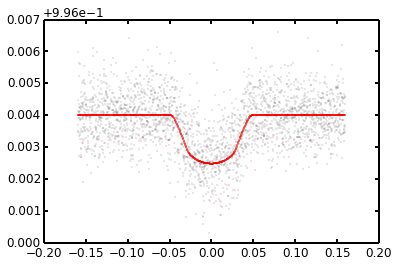

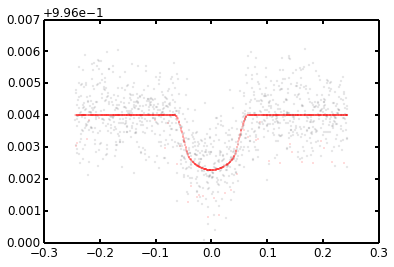

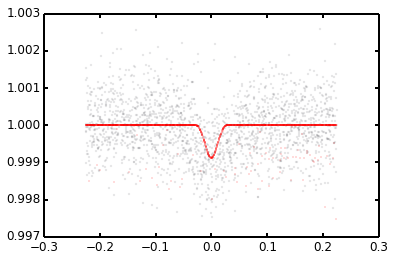

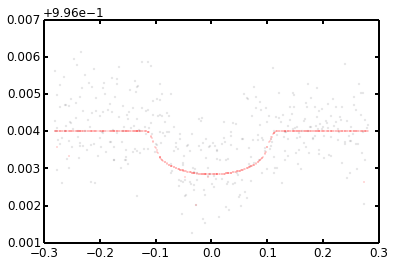

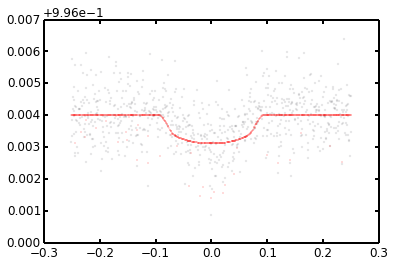

In [6]:
params = model.archive_params
#params[3] = 0.5 #dilution
f = model.light_curve(params, model.time)

for i in range(model.n_planets):
    plt.figure()
    tfold = model.tfold(i) #times folded on proper period 
    close = model.close(i, width=2) #points close to transit
    plt.plot()
    plt.plot(tfold[close], model.flux[close], 'o', ms=0.2, alpha=0.35);
    plt.plot(tfold[close], f[close], 'ro', ms=0.3, mec='r', mew=0.5);
    


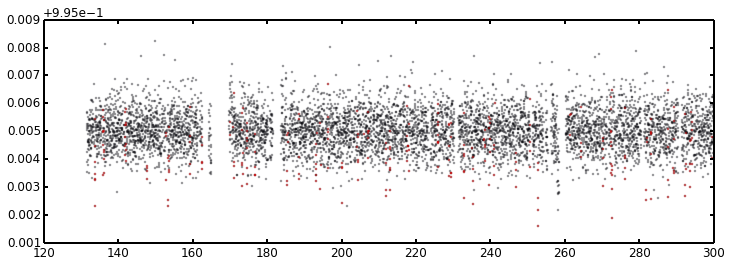

In [7]:
npts = 2000
tmax = 300
plt.figure(figsize=(12,4))
plt.plot(model.time[model.time < tmax], model.flux[model.time < tmax], 'o', ms=0.3)
mask = (model.time < tmax) & model.any_intransit
plt.plot(model.time[mask], model.flux[mask], 'ro', ms=0.3, mec='r');

In [6]:
import numpy.ma as ma

x = ma.masked_array(np.arange(5), mask=[0,1,0,0,0])
y = ma.masked_array(x, mask=[0,0,1,0,0])

y

masked_array(data = [0 -- -- 3 4],
             mask = [False  True  True False False],
       fill_value = 999999)

In [6]:
import numpy.ma as ma


def medfilt (x, k, mask=None):
    """Apply a length-k median filter to a 1D array x.
    Boundaries are extended by repeating endpoints.
    
    adapted from https://gist.github.com/bhawkins/3535131
    """
    assert k % 2 == 1, "Median filter length must be odd."
    assert x.ndim == 1, "Input must be one-dimensional."
    
    if mask is None:
        mask = np.zeros_like(x).astype(bool)
    
    x[mask] = np.nan
    
    k2 = (k - 1) // 2
    y = np.zeros ((len (x), k), dtype=x.dtype)
    y[:,k2] = x
    for i in range (k2):
        j = k2 - i
        y[j:,i] = x[:-j]
        y[:j,i] = x[0]
        y[:-j,-(i+1)] = x[j:]
        y[-j:,-(i+1)] = x[-1]
        
    return np.nanmedian(y,axis=1)
    

In [14]:
#from scipy.signal import medfilt
import pandas as pd
filtered = pd.rolling_median(model._flux, 75, center=True, min_periods=3)

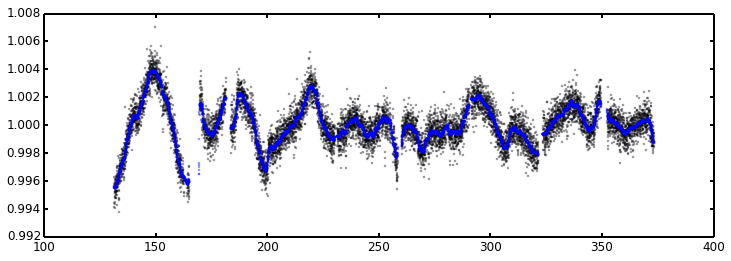

In [15]:
tmax = 400
plt.figure(figsize=(12,4))
plt.plot(model.time[model.time < tmax], model.flux[model.time < tmax], 'o', ms=0.3)
plt.plot(model._time[model._time < tmax], filtered[model._time < tmax], 'bo', ms=0.3, mec='b');

In [26]:
pd.rolling_median?

In [17]:
med = lambda x: pd.Series(x).dropna().median()

pd.rolling_median(np.array([1,2,2,2,3,3,np.nan,np.nan,1,5,4,4,2]), 3, min_periods=1)

array([ 1. ,  1.5,  2. ,  2. ,  2. ,  3. ,  3. ,  3. ,  1. ,  3. ,  4. ,
        4. ,  4. ])

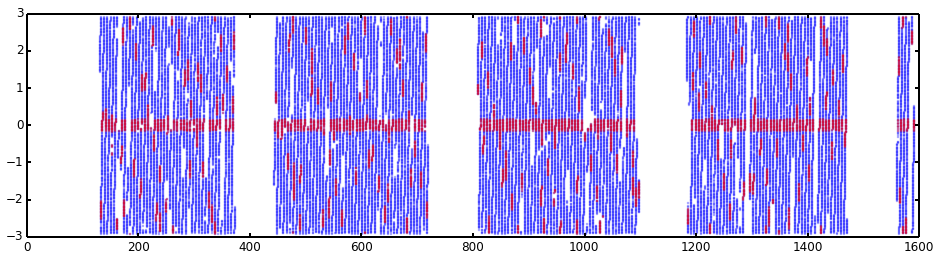

In [15]:
def transit_stack(model, i=0, width=2, i_transit=None):
    """    
    """

    tfold = model.tfold(i)
    close = model.anyclose
    
    
    t = model.time
    
    plt.figure(figsize=(16,4))
    plt.plot(t, tfold, '.', ms=0.5)
    if i_transit is None:
        plt.plot(t[close], tfold[close], 'r.', ms=0.5)
    else:
        mask = model.transit_mask(i, i_planet, width=width)
        plt.plot(t[mask], tfold[mask])
    
transit_stack(model)
    
    

In [18]:
%timeit f[anyclose] = model.light_curve(params, lcdata['TIME'][anyclose])
%timeit f[~anyclose] = model.light_curve(params, lcdata['TIME'][~anyclose])
%timeit f = model.light_curve(params, lcdata['TIME'])

10 loops, best of 3: 131 ms per loop
100 loops, best of 3: 3.39 ms per loop
10 loops, best of 3: 133 ms per loop


In [20]:
from scipy.optimize import minimize
def obj(p):
    return -model.lnlike(p)

fit = minimize(obj, params, method='Nelder-Mead', options={'disp':True})

Optimization terminated successfully.
         Current function value: 0.006263
         Iterations: 696
         Function evaluations: 1143


[  4.72954152e+00   2.81073558e-01   5.87961813e-01   1.91477839e-04
   5.84164158e+00   1.35923004e+02   5.74815816e-01   3.54667764e-02
   9.97333917e-03   9.56463017e-04]


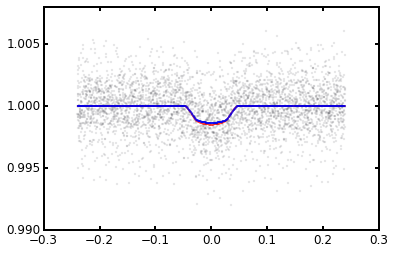

In [21]:
f_fit = np.ones_like(lcdata['TIME'])
f_fit[anyclose] = model.light_curve(fit.x, lcdata['TIME'][anyclose])

print fit.x

for period, epoch, duration in zip(periods, epochs, durations):
    plt.figure()
    tfold = (lcdata['TIME'] + period/2 - epoch) % period - (period/2)
    close = np.array(np.absolute(tfold) < 3*(duration/24))
    plt.plot(tfold[close], flux[close], 'o', ms=0.2, alpha=0.35);
    plt.plot(tfold[close], f[close], 'ro', ms=0.2, mec='r', mew=0.2);
    plt.plot(tfold[close], f_fit[close], 'bo', ms=0.2, mec='b', mew=0.4)

In [59]:
import emcee as emcee

ndim = len(params)
nwalkers = 100
p0 = (1 + np.random.normal(0,0.01,size=(ndim,nwalkers))) * np.array(params)[:,None]

sampler = emcee.EnsembleSampler(nwalkers, ndim, model.lnlike)

In [61]:
sampler.run_mcmc(p0, 10)

ValueError: low >= high

In [5]:
1 == 1 == 1

True

In [10]:
np.ones_like(4)

array(1)

In [13]:
np.array(2).size

1

In [18]:
np.ma.masked_array

numpy.ma.core.MaskedArray